## Order and Online customer behavior data analytics

In [89]:
# All basic imports
import numpy as np
import pandas as pd
import os
from datetime import datetime
from datetime import timedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [12,8]
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read Data
onlineData = pd.read_csv("online.csv")
orderData = pd.read_csv("order.csv")

## Exploration and understanding of the data sets

In [3]:
onlineData.head()

,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,NaN,1
3,880408,90673,2017-10-28 13:42:38,39168,1,NaN,1
4,2612179,191542,2016-05-17 06:30:32,47616,1,NaN,1


In [4]:
orderData.head()

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.30
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.10
2,18944,28906,2017-04-23 21:31:03,NaN,1,141.66
3,36096,62681,2016-02-25 07:16:33,NaN,1,36.82
4,1,1,2017-06-12 08:27:59,NaN,1,8.35


My Assumptions is that online browsing category is our target variable. Our objective is to create a data set by merging online session activies to its corresponding conversion result in orders table and use the attribtues of converstion information to train a predictive model.

Vistiors ids are the devices used by the respective customer to interact with the website or the mobile application. Session ids are the session keys which indentify the session inactivity. If user does not interact for more than 30 mins a new session key is created for that visitor id if the customers has chosen to return to the site or the application.

In [5]:
print(" There are in total " + str(len(onlineData.custno.unique())) + " unique customers in online data")
print(" There are in total " + str(len(orderData.custno.unique())) + " unique customers in orders data")

 There are in total 57584 unique customers in online data
 There are in total 70264 unique customers in orders data


In [6]:
# created a separate columns for data and time for future use

onlineData['date'] = onlineData.dt.apply(lambda x : x[0:10])
onlineData['time'] = onlineData.dt.apply(lambda x : x[11:])

orderData['date'] = orderData.orderdate.apply(lambda x : x[0:10])
orderData['time'] = orderData.orderdate.apply(lambda x : x[11:])

In [7]:
# deleting the datetimes columns

del orderData['orderdate']
del onlineData['dt']

There are various instances where an order does not have the session activity info in the online data, for instance:

### Custno 1

In [8]:
#Result 1
onlineData[(onlineData.custno == 1) ]

,session,visitor,custno,category,event1,event2,date,time


In [9]:
#Result 2
orderData[(orderData.custno == 1)]

,custno,ordno,prodcat2,prodcat1,revenue,date,time
4,1,1,NaN,1,8.35,2017-06-12,08:27:59


Example of an instance which has the online active data on the same day by online activity was logged after order was purchased

### Custno 637

In [10]:
#Result 1
onlineData[(onlineData.custno == 637) & (onlineData.date == "2017-10-04")]

,session,visitor,custno,category,event1,event2,date,time
71874,9,405166,637,2,NaN,3,2017-10-04,13:36:14
135720,9,405166,637,2,NaN,7,2017-10-04,13:07:03


In [11]:
#Result 2
orderData[(orderData.custno == 637) & (orderData.date == "2017-10-04")]

,custno,ordno,prodcat2,prodcat1,revenue,date,time
153499,637,84765,25.0,7,68.48,2017-10-04,02:08:35
166738,637,151367,30.0,3,119.46,2017-10-04,13:47:35


If you refer the result 2 index 153499, there was no online activity logged before that order. Whereas in result 1 we see that there are two activites logged within 30 mins period having same session id. 

Later there was a purchase made by the customer on 13:47:35, approximately after 10 mins.

Therefore, I will be keeping only the records which has the online session data after merging order and online table.

In [12]:
data = pd.merge(onlineData, orderData,  how='outer', left_on=['custno','date'], right_on = ['custno','date'])

In [13]:
def timeDiff(x,y):
    format = '%H:%M:%S'
    return (datetime.strptime(x, format) - datetime.strptime(y, format))

def sameSession(x):
    if(x.seconds < 1800):
        return 1
    else:
        return 0

In [14]:
data.shape

(1196649, 13)

In [15]:
data.head()

,session,visitor,custno,category,event1,event2,date,time_x,ordno,prodcat2,prodcat1,revenue,time_y
0,419542.0,140970.0,3840,1.0,NaN,1.0,2016-09-16,05:03:23,NaN,NaN,NaN,NaN,NaN
1,3030130.0,14501.0,70400,1.0,NaN,1.0,2017-11-13,04:58:12,NaN,NaN,NaN,NaN,NaN
2,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,3.0,2.0,101.00,16:15:23
3,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,6.0,3.0,81.70,16:15:23
4,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,9.0,3.0,21.81,16:15:23


In [16]:
data = data[data.time_y.notnull()]

In [17]:
data = data[data.time_x.notnull()]

In [18]:
data.shape

(107164, 13)

In [19]:
data['timeDiff'] = data.apply(lambda x: timeDiff(x['time_y'],x['time_x']), axis = 1)

In [20]:
data['sameSession'] = data['timeDiff'].apply(lambda x : sameSession(x))

In [21]:
data.shape

(107164, 15)

In [22]:
data = data[data.sameSession == 1 ]

In [23]:
data['timediff'] = data['timeDiff'].apply(lambda x: x.seconds)

In [24]:
data.shape

(32803, 16)

In [25]:
data.head()

,session,visitor,custno,category,event1,event2,date,time_x,ordno,prodcat2,prodcat1,revenue,time_y,timeDiff,sameSession,timediff
2,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,3.0,2.0,101.00,16:15:23,00:04:45,1,285
3,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,6.0,3.0,81.70,16:15:23,00:04:45,1,285
4,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,9.0,3.0,21.81,16:15:23,00:04:45,1,285
82,301695.0,393923.0,3844,1.0,2.0,1.0,2016-08-17,18:30:01,42965.0,28.0,7.0,33.98,18:33:05,00:03:04,1,184
83,301695.0,393923.0,3844,1.0,2.0,1.0,2016-08-17,18:30:01,42965.0,94.0,7.0,50.02,18:33:05,00:03:04,1,184


In [26]:
len(data.custno.unique())

10323

In [27]:
data = data.reset_index()

In [28]:
data.head()

,index,session,visitor,custno,category,event1,event2,date,time_x,ordno,prodcat2,prodcat1,revenue,time_y,timeDiff,sameSession,timediff
0,2,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,3.0,2.0,101.00,16:15:23,00:04:45,1,285
1,3,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,6.0,3.0,81.70,16:15:23,00:04:45,1,285
2,4,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,9.0,3.0,21.81,16:15:23,00:04:45,1,285
3,82,301695.0,393923.0,3844,1.0,2.0,1.0,2016-08-17,18:30:01,42965.0,28.0,7.0,33.98,18:33:05,00:03:04,1,184
4,83,301695.0,393923.0,3844,1.0,2.0,1.0,2016-08-17,18:30:01,42965.0,94.0,7.0,50.02,18:33:05,00:03:04,1,184


In [29]:
del data['index']

In [30]:
data.dtypes

session                float64
visitor                float64
custno                   int64
category               float64
event1                 float64
event2                 float64
date                    object
time_x                  object
ordno                  float64
prodcat2               float64
prodcat1               float64
revenue                float64
time_y                  object
timeDiff       timedelta64[ns]
sameSession              int64
timediff                 int64
dtype: object

In [31]:
data['date'] = pd.to_datetime(data['date'])

In [32]:
data = data.sort_values('session')

In [33]:
data.head()

,session,visitor,custno,category,event1,event2,date,time_x,ordno,prodcat2,prodcat1,revenue,time_y,timeDiff,sameSession,timediff
2349,9.0,405166.0,637,2.0,NaN,3.0,2017-10-04,13:36:14,151367.0,30.0,3.0,119.46,13:47:35,00:11:21,1,681
3729,21.0,383763.0,69508,2.0,NaN,4.0,2016-03-16,20:57:53,148458.0,13.0,4.0,105.21,21:00:23,00:02:30,1,150
5506,32.0,278715.0,4008,2.0,NaN,7.0,2016-07-24,12:34:45,81006.0,50.0,7.0,25.40,12:41:53,00:07:08,1,428
3098,55.0,466079.0,3098,2.0,NaN,4.0,2017-09-17,13:08:44,3629.0,11.0,1.0,19.70,13:13:14,00:04:30,1,270
3100,55.0,466079.0,3098,2.0,NaN,4.0,2017-09-17,13:08:44,3629.0,89.0,1.0,35.97,13:13:14,00:04:30,1,270


In [34]:
max(data.date) - min(data.date)

Timedelta('730 days 00:00:00')

In [35]:
temp = data.groupby(['session']).sum()

In [36]:
temp = temp.sort_index()

In [37]:
temp.head()

,visitor,custno,category,event1,event2,ordno,prodcat2,prodcat1,revenue,sameSession,timediff
session,,,,,,,,,,,
9.0,405166.0,637,2.0,NaN,3.0,151367.0,30.0,3.0,119.46,1,681
21.0,383763.0,69508,2.0,NaN,4.0,148458.0,13.0,4.0,105.21,1,150
32.0,278715.0,4008,2.0,NaN,7.0,81006.0,50.0,7.0,25.40,1,428
55.0,1398237.0,9294,6.0,NaN,12.0,10887.0,112.0,3.0,56.22,3,810
77.0,50632.0,3844,2.0,NaN,8.0,153500.0,44.0,3.0,38.83,1,1042


In [38]:
behaviorData = temp[['revenue','sameSession']]

In [53]:
behaviorData = behaviorData.reset_index()

In [97]:
tempData = data[['session','custno']]

In [55]:
tempData = tempData.drop_duplicates()

In [57]:
tempData = tempData.reset_index()

In [58]:
behaviorData['custno'] = tempData['custno']

In [59]:
behaviorData.head()

,session,revenue,sameSession,custno
0,9.0,119.46,1,637
1,21.0,105.21,1,69508
2,32.0,25.40,1,4008
3,55.0,56.22,3,3098
4,77.0,38.83,1,3844


In [71]:
behaviorData.columns = ['session','revenue','countOfProducts','custno']

In [143]:
tempData = data[['custno', 'date','session']]

In [144]:
tempData = tempData.drop_duplicates(['session'])

In [145]:
tempData = tempData.sort_values(['custno'])

In [147]:
tempData.index = tempData.session

In [148]:
tempData

,custno,date,session
session,,,
809678.0,8,2017-03-29,809678.0
3632314.0,8,2016-12-11,3632314.0
3189010.0,9,2016-05-20,3189010.0
842759.0,9,2016-05-21,842759.0
3467201.0,9,2017-10-29,3467201.0
2959660.0,9,2017-07-23,2959660.0
3555117.0,9,2016-07-21,3555117.0
632669.0,9,2016-05-07,632669.0
404917.0,9,2016-10-16,404917.0


In [135]:
tempData.shape

(16752, 2)

In [142]:
behaviorData.head()

,session,revenue,countOfProducts,custno,date
session,,,,,
9.0,9.0,119.46,1,637,2017-05-24
21.0,21.0,105.21,1,69508,NaT
32.0,32.0,25.40,1,4008,NaT
55.0,55.0,56.22,3,3098,NaT
77.0,77.0,38.83,1,3844,2016-08-17


In [ ]:
behaviorData.index = behaviorData.session

In [149]:
behaviorData['date'] = tempData['date']

In [150]:
behaviorData.head()

,session,revenue,countOfProducts,custno,date
session,,,,,
9.0,9.0,119.46,1,637,2017-10-04
21.0,21.0,105.21,1,69508,2016-03-16
32.0,32.0,25.40,1,4008,2016-07-24
55.0,55.0,56.22,3,3098,2017-09-17
77.0,77.0,38.83,1,3844,2016-03-01


In [151]:
del behaviorData['session']

In [152]:
behaviorData.head()

,revenue,countOfProducts,custno,date
session,,,,
9.0,119.46,1,637,2017-10-04
21.0,105.21,1,69508,2016-03-16
32.0,25.40,1,4008,2016-07-24
55.0,56.22,3,3098,2017-09-17
77.0,38.83,1,3844,2016-03-01


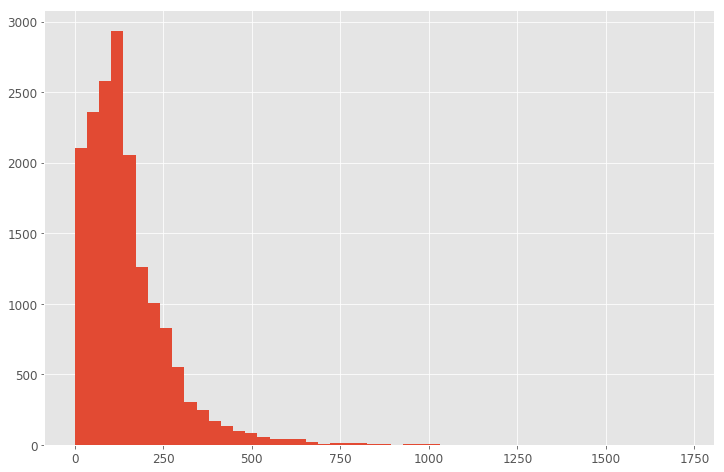

In [93]:
behaviorData.revenue.hist(bins= 50)
plt.show()

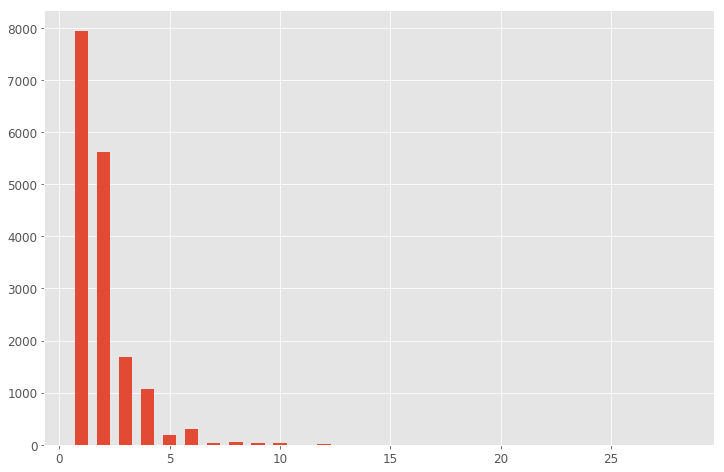

In [92]:
temp = behaviorData.groupby(['countOfProducts']).count()
plt.bar(temp.index, temp.session, width = 0.6)
plt.show()

## Feature engineering

## Feature selection


## Model design and sampling


## Model generation


## Model evaluation

In [ ]:
OnlineCustomers = onlineData.custno

In [ ]:
OrderCustomers = orderData.custno

In [ ]:
# This code will take 15 mins to run, but pull the custno 
customerList = []
for i in OnlineCustomers.unique():
    if(i in list(OrderCustomers.unique())):
        customerList.append(i)

In [ ]:
len(customerList)

In [ ]:
OrderDates = orderData.date.unique()

In [ ]:
# 18 secs

Datelist = []
for i in onlineData.date.unique():
    if(i in list(orderData.date.unique())):
        Datelist.append(i)

In [ ]:
len(Datelist)

In [ ]:
dateCustomerCombo = orderData[["custno","date"]]  

In [ ]:
dateCustomerCombo = dateCustomerCombo.drop_duplicates()

In [ ]:
onlineOrderedData = pd.read_csv('orderedData.csv')

In [ ]:
onlineOrderedData.index = onlineOrderedData['Unnamed: 0']

In [ ]:
del onlineOrderedData['Unnamed: 0']

In [ ]:
plt.hist(onlineOrderedData[onlineOrderedData.category == 1])

In [ ]:
 test = onlineData[onlineData.ordered == 1]

In [ ]:
test.groupby(['category']).size()

In [ ]:
test.groupby([test.event1]).size()